In [202]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens


import sklearn.feature_selection as feature_selection

import pickle

from rfpimp import dropcol_importances

In [3]:
age_clast_model = pickle.load(open('age_clast_model.mdl', 'rb'))

In [4]:
age_cls_model = pickle.load(open('age_cls_model_02.mdl', 'rb'))

In [5]:
age_reg_model = pickle.load(open('age_reg_model_02.mdl', 'rb'))

In [6]:
lda = pickle.load(open('lda_01.mdl', 'rb'))

In [7]:
qda = pickle.load(open('qda_01.mdl', 'rb'))

In [8]:
abc = pickle.load(open('abc_01.mdl', 'rb'))

In [9]:
etc = pickle.load(open('etc_01.mdl', 'rb'))

In [10]:
rfc = pickle.load(open('rfc_01.mdl', 'rb'))

In [11]:
lr = pickle.load(open('lr_01.mdl', 'rb'))

In [12]:
rc = pickle.load(open('rc_01.mdl', 'rb'))

In [13]:
svc = pickle.load(open('svc_01.mdl', 'rb'))

In [14]:
nusvc = pickle.load(open('nusvc_01.mdl', 'rb'))

#### Plotting Helper functions

In [15]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

#### Helper functions for model training

In [16]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

### Import data

In [26]:
#import train dataset
filename_tr = 'train.csv'
data_train = pd.read_csv(filename_tr)

#import test dataset
filename_tes = 'test.csv'
data_test = pd.read_csv(filename_tes)

In [27]:
data_test = data_test.fillna(value={'Fare':0})

In [28]:
#Concatinate train & test data (to make sure that all unique titles are captured)
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [29]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(drop=True), data_encoded], axis=1)

In [30]:
def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    data = name_encoder(data)
    data['ttl'] = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    data['ttl'] = data['ttl'].apply(lambda i: mask[i])
    return data

In [31]:
#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data

In [32]:
# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

In [33]:
# Clean ticket ID from all punctuation and spaces
df_fam = data_tot.copy()
df_fam['Ticket'] = df_fam['Ticket'].apply(lambda i: clean_text(i))

In [34]:
families0 = df_fam.loc[(df_fam['SibSp']>0) & (df_fam['Parch']==0)]
families1 = df_fam.loc[df_fam['Parch']>0]
singles = df_fam.loc[(df_fam['SibSp']==0) & (df_fam['Parch']==0)]

In [35]:
# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

In [36]:
#singles
sig_grp = singles.groupby('Ticket')
#families NO children
fam0_grp = families0.groupby('Ticket')
#families w/children
fam1_grp = families1.groupby('Ticket')

#no family, unique ticket
sig0 = grps_by_size(sig_grp)[0]
#no family, matching tickets
sig1 = grps_by_size(sig_grp)[1]
#has family, no children, unique ticket
fam0 = grps_by_size(fam0_grp)[0]
#has family, no children, matching ticket
fam1 = grps_by_size(fam0_grp)[1]
#has family, has children, unique ticket
famch0 = grps_by_size(fam1_grp)[0]
#has family, has children, matching ticket
famch1 = grps_by_size(fam1_grp)[1]

In [37]:
# Family groups
fam_grps = [sig0, sig1, fam0, fam1, famch0, famch1]

In [38]:
# Make a mask of family groups labels
fgrp_mask = {}
for idx, grp in enumerate(fam_grps):
    for pid in grp['PassengerId']:
        fgrp_mask[pid] = idx

In [39]:
# Make a mask of ticket fare
fare_mask = {}
for tic in df_fam['Ticket'].unique():
    # subgroup with matching tickets
    tic_grp = df_fam.loc[df_fam['Ticket']==tic]
    
    # passenger class that the subgroup belongs to
    c = tic_grp['Pclass'].values[0]
    
    # ticket fare of the subgroup
    # all subgroup members have the same ticket fare initially
    fare_grp = tic_grp['Fare'].values[0]
    
    # if a subgroup fare is 0 then assign a mean of the fare of the Pclass that the subgroup belongs to
    if (fare_grp == 0) or (fare_grp is None):
        fare_i = np.mean(df_fam.loc[df_fam['Pclass']==c, 'Fare'])
        for pid in tic_grp['PassengerId']:
            fare_mask[pid] = fare_i

    # recalculate fare for subrgoup members: fare_i = group_fare / n_members
    if len(tic_grp.index) > 1:
        if fare_grp > 0:
            
            if np.mean(tic_grp['Fare'])==fare_grp: #check if all group members have same fare
                fare_i = fare_grp / len(tic_grp.index)
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = fare_i
            else:
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = tic_grp.loc[tic_grp['PassengerId']==pid, 'Fare'].values[0]
    # keep fare value for passengers with unuque tickets
    else:
        if fare_grp > 0:
            fare_i = fare_grp
            for pid in tic_grp['PassengerId']:
                fare_mask[pid] = fare_i

In [437]:
# Make a mask of ticket codes
m_tickets = []
for tic in df_fam['Ticket'].unique():
    if len(df_fam.loc[df_fam['Ticket']==tic].index) > 1:
        m_tickets.append(tic)

ticket_mask = {}        
for pid in df_fam['PassengerId']:
    tic = df_fam.loc[df_fam['PassengerId']==pid, 'Ticket'].values[0]
    if tic in m_tickets:
        ticket_mask[pid] = 1
    else:
        ticket_mask[pid] = 0

In [114]:
# # Make a mask of ticket codes
# m_tickets = {}
# for tic in df_fam['Ticket'].unique():
#     m_tickets[tic] = len(df_fam.loc[df_fam['Ticket']==tic].index)

# ticket_mask = {}        
# for pid in df_fam['PassengerId']:
#     tic = df_fam.loc[df_fam['PassengerId']==pid, 'Ticket'].values[0]
#     ticket_mask[pid] = m_tickets[tic]

In [42]:
# Encode family groups
# This function adds new class variable 'fgrp' that indicates a group that a passenger belongs to.
def family_groups_encoder(data, fgrp_mask):
    data['fgrp'] = data['PassengerId'].apply(lambda i: fgrp_mask[i])
    data['fgrp'] = data['fgrp'].apply(lambda i: len(data.loc[data['fgrp']==i].index))
    return data

# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class.
def fare_encoder(data, fare_mask):
    data['Fare'] = data['PassengerId'].apply(lambda i: fare_mask[i])
    return data

# Encode tickets
def ticket_encoder(data, ticket_mask):
    data['Ticket'] = data['PassengerId'].apply(lambda i: ticket_mask[i])
    return data

In [43]:
# Log-transform 'Fare'
def fare_transformer(data):
    data['Fare'] = data['Fare'].apply(np.log)
    return data

In [44]:
# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':0, 'female':1}
    df = data['Sex'].apply(lambda i: mask[i])
    return pd.concat([data.drop(columns=['Sex']), df], axis=1)

# Add 'Family size'
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch']
#     data['famsize'] = data['famsize'].apply(lambda i: i if i<8 else 8)
    return data

#Encoding 'Pclass' (to labels 0,1,2)
def pclass_encoder(data):
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

def cabin_encoder(data):
    data = data.fillna(value={'Cabin': 0})
    data['Cabin'] = data['Cabin'].apply(lambda i: 1 if i!=0 else 0)
    return data

In [45]:
def age_transformer(data, model):
    data['Age_trans'] = data['Age'].apply(np.log)
    X = data['Age_trans'].to_frame()
    data['Age_cls'] = model.predict(X)
    data['Age_cls'] = data['Age_cls'].astype(int)
    return data

### Predict missing missing values for age

In [397]:
data = family_groups_encoder(data_tot.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)

data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[data['Age'].notna()].copy()
data = age_transformer(data, age_clast_model)
data['Age'] = data['Age'].apply(np.log)
data = cabin_encoder(data)

data = data[['Age', 'Age_cls', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])

In [398]:
# data['ttl'] = data['ttl'].apply(lambda i: len(data.loc[data['ttl']==i].index))

In [399]:
# data['Pclass'] = data['Pclass'].apply(lambda i: len(data.loc[data['Pclass']==i].index))

In [400]:
# data['Embarked'] = data['Embarked'].apply(lambda i: len(data.loc[data['Embarked']==i].index))

In [401]:
data.head()

,Age,Age_cls,Fare,fgrp,famsize,Ticket,ttl_1,ttl_2,ttl_3,ttl_4,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
0,3.091042,2,1.981001,38,1,0,1,0,0,0,0,0,1,0,1,0
1,3.637586,0,3.573515,174,1,1,0,1,0,0,1,0,0,1,0,0
2,3.258097,2,2.070022,682,0,0,0,0,1,0,0,0,1,0,1,0
3,3.555348,0,3.279030,174,1,1,0,1,0,0,1,0,0,0,1,0
4,3.555348,0,2.085672,682,0,0,1,0,0,0,0,0,1,0,1,0


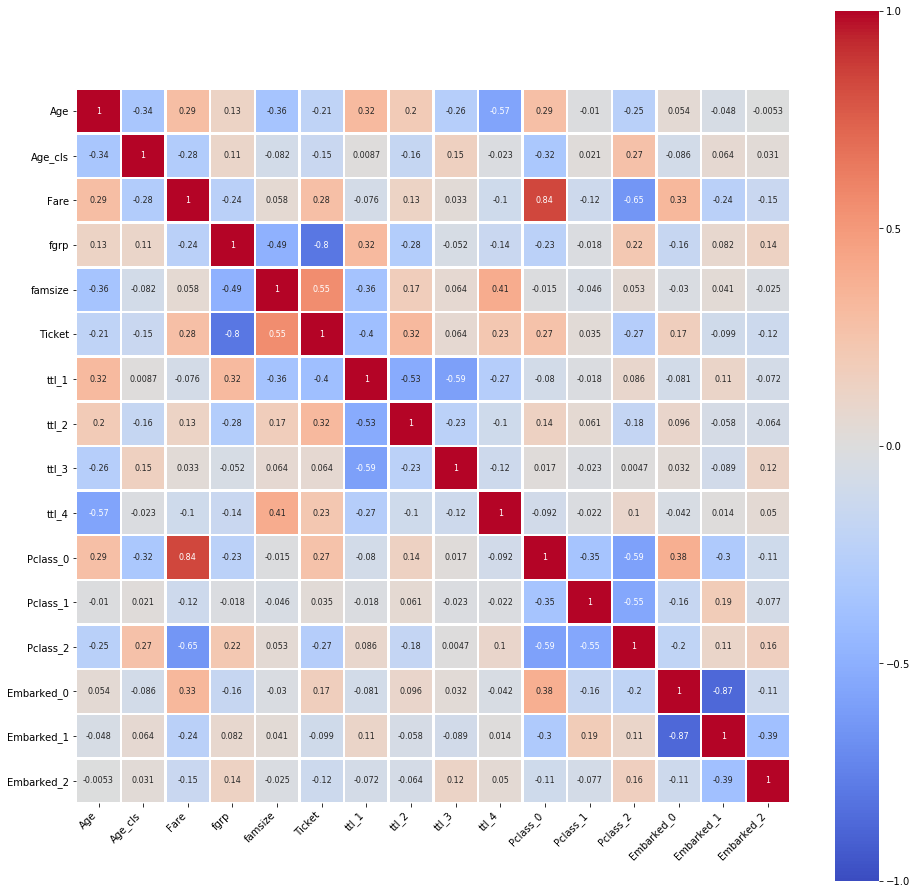

In [402]:
fig = plt.figure()
fig.set_size_inches(16, 16)
corr_matrix = data.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

In [278]:
X = data.drop(columns=['Age', 'Age_cls'])
y = data['Age_cls']

In [279]:
X.columns

Index(['Age_cls', 'Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2',
       'ttl_3', 'ttl_4', 'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0',
       'Embarked_1', 'Embarked_2'],
      dtype='object')

In [274]:
len(X.columns)

15

In [232]:
def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

In [233]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)

#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc_ovr':  metrics.make_scorer(roc_auc_score_ovr, needs_proba=True),
           'roc_auc_ovo':  metrics.make_scorer(roc_auc_score_ovo, needs_proba=True),
           'precision_macro': 'precision_macro'}
refit = 'roc_auc_ovr'

##### Initial model

In [234]:
params = {'learning_rate': 0.1, 
          'n_estimators': 85,
          'min_weight_fraction_leaf': 0.099, 
          'min_impurity_decrease': 0.05,
          'max_depth': 10,
          'subsample': 1.0,
          'ccp_alpha': 0.0}

age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state, **params)
cv_rep(age_cls_model, X, y, cv, scoring)

,balanced_accuracy,roc_auc_ovr,roc_auc_ovo,precision_macro
mean_train,0.783912,0.883295,0.922027,0.788719
std_train,0.011968,0.005572,0.003540,0.009903
mean_test,0.735017,0.830003,0.885214,0.734003
std_test,0.030242,0.016844,0.015603,0.020992


##### Tune parameters

In [235]:
param_ranges = {'learning_rate': np.linspace(0.001, 2, 40), 'n_estimators': np.arange(5, 100, 20)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.795520     0.883776     0.921664         0.808787
std_train            0.015491     0.004878     0.003354         0.014601
mean_test            0.739434     0.830825     0.885898         0.741228
std_test             0.025462     0.015580     0.015055         0.025107
{'learning_rate': 0.20602564102564103, 'n_estimators': 85}


In [236]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.0001, 0.1, 40)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.818366     0.885353     0.934930         0.824631
std_train            0.009561     0.005969     0.002642         0.013149
mean_test            0.748011     0.833197     0.889792         0.746813
std_test             0.021075     0.014135     0.011503         0.015871
{'min_impurity_decrease': 0.015469230769230768, 'min_weight_fraction_leaf': 0.14897435897435898}


In [237]:
param_ranges = {'subsample': np.linspace(0.1, 1.0, 50), 'max_depth': np.arange(3, 10)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.794291     0.885353     0.925087         0.800832
std_train            0.010653     0.005969     0.003964         0.015235
mean_test            0.742212     0.833197     0.888954         0.740901
std_test             0.022388     0.014135     0.011906         0.024405
{'max_depth': 5, 'subsample': 1.0}


In [238]:
param_ranges = {'ccp_alpha': np.linspace(0.00001,0.0001, 99)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.788292     0.881706     0.924597         0.799492
std_train            0.010470     0.005751     0.003873         0.013195
mean_test            0.741041     0.833653     0.889039         0.739757
std_test             0.021676     0.014937     0.012107         0.021055
{'ccp_alpha': 5.959183673469388e-05}


In [251]:
# Save model
pickle.dump(age_cls_model, open('age_cls_model_02.mdl', 'wb'))

In [37]:
def feature_importance(model, X_train, y_train, X_test, y_test, metric, label=None):
    feature_importance = dropcol_importances(model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=metric)
    if label is None:
        label = model.__class__.__name__
    feature_importance.columns = [label]
    return feature_importance

In [1299]:
# feature_importance_base = None
# for i, m in enumerate(base_models_surv):
#     lbl, model = m
#     if feature_importance_base is None:
#         feature_importance_base = feature_importance(model, X_train, y_train, X_test, y_test, metric=dropcol_imp_accuracy_metric, label=lbl)
#     else:
#         feature_importance_base = feature_importance_base.merge(feature_importance(model, X_train, y_train, X_test, y_test, metric=dropcol_imp_accuracy_metric, label=lbl),
#                                                                     left_index=True, right_index=True)

In [1300]:
# feature_importance_base

In [34]:
# feature_importance_base.T.apply(np.mean).sort_values(ascending=False)

In [239]:
X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.3, shuffle=True, random_state=30)

In [240]:
feature_importance(age_cls_model, 
                   X_train, y_train, X_test, y_test, 
                   metric=metrics.make_scorer(roc_auc_score_ovr, needs_proba=True), 
                   label=None).T

Feature,ttl_2,ttl_1,Pclass_0,Embarked_0,Pclass_1,ttl_4,Embarked_2,fgrp,Embarked_1,ttl_3,Pclass_2,Ticket,Fare
GradientBoostingClassifier,0.0219,0.013198,0.000985,0.000917,0.00043,0.0,0.0,-0.000239,-0.000302,-0.001705,-0.004873,-0.005952,-0.009949


#### Train model for age prediction

In [413]:
# train test split
X = data.drop(columns=['Age'])
y = data['Age']

In [414]:
X = pd.get_dummies(X, columns=['Age_cls'])

In [415]:
X.columns

Index(['Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2', 'ttl_3', 'ttl_4',
       'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Age_cls_0', 'Age_cls_1', 'Age_cls_2'],
      dtype='object')

In [416]:
#common random_state
random_state=30

#cross validation strategy
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)

#cross validation metrics
scoring = {'explained_variance':  'explained_variance', 'r2': 'r2'}
refit='r2'

##### Initial model

In [417]:
params = {'learning_rate': 0.1, 
          'n_estimators': 55,
          'min_weight_fraction_leaf': 0.001, 
          'min_impurity_decrease': 0.5,
          'max_depth': 3,
          'subsample': 1.0,
          'ccp_alpha': 0.001}

age_reg_model = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state, **params)
cv_rep(age_reg_model, X, y, cv, scoring)

,explained_variance,r2
mean_train,0.854543,0.854543
std_train,0.006892,0.006892
mean_test,0.797510,0.796197
std_test,0.041966,0.042347


##### Tune parameters

In [418]:
param_ranges = {'learning_rate': np.linspace(0.01, 0.1, 40), 'n_estimators': np.arange(5, 100, 25)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.854002  0.854002
std_train             0.006709  0.006709
mean_test             0.798625  0.797286
std_test              0.040998  0.041427
{'learning_rate': 0.09076923076923077, 'n_estimators': 55}


In [419]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.5, 40)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.854002  0.854002
std_train             0.006709  0.006709
mean_test             0.798625  0.797286
std_test              0.040998  0.041427
{'min_impurity_decrease': 0.5, 'min_weight_fraction_leaf': 0.001}


In [420]:
param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.0, 50)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.847369  0.847365
std_train             0.006763  0.006764
mean_test             0.799707  0.798426
std_test              0.043946  0.044485
{'max_depth': 2, 'subsample': 0.7612244897959184}


In [421]:
param_ranges = {'ccp_alpha': np.linspace(0.0001, 0.01, 99)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.847301  0.847297
std_train             0.006876  0.006877
mean_test             0.799762  0.798479
std_test              0.044000  0.044535
{'ccp_alpha': 0.0010091836734693878}


In [422]:
# Save model
pickle.dump(age_reg_model, open('age_reg_model_02.mdl', 'wb'))

In [253]:
X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.3, shuffle=True, random_state=30)

In [255]:
feature_importance(age_reg_model, 
                   X_train, y_train, X_test, y_test, 
                   metric='r2', 
                   label=None).T

Feature,Fare,ttl_3,Pclass_0,Pclass_2,Embarked_1,Age_cls_1,fgrp,Age_cls_2,ttl_2,Pclass_1,ttl_1,ttl_4,Embarked_0,famsize,Ticket,Embarked_2,Age_cls_0
GradientBoostingRegressor,0.007519,0.003086,0.001761,0.001649,0.001126,0.000989,0.000955,0.000799,0.000487,0.000405,0.00016,0.000003,-0.000655,-0.001108,-0.001178,-0.001578,-0.003079


In [47]:
#Age encoder (predict missing vakues and log-transform)
def age_predictor(data, age_cls_model, age_reg_model):
    cols = ['Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']

    data_na = data.loc[data['Age'].isnull()].copy()
    data_notna = data.loc[data['Age'].notna()].copy()

    # transform non-null age values
#     data_notna['Age'] = data_notna['Age'].apply(np.log)

    # predict class labels
    X = data_na[cols].copy()
    X = pd.get_dummies(X, columns=['ttl', 'Pclass', 'Embarked'])
    X['Age_cls'] = age_cls_model.predict(X.drop(columns='famsize'))

    # predict age
    X = pd.get_dummies(X, columns=['Age_cls'])
    data_na['Age'] = age_reg_model.predict(X)
#     data_na['Age'] = data_na['Age'].apply(np.exp)
    return pd.concat([data_na, data_notna])

## Predict survivals

#### Preprocessind data

In [479]:
data = family_groups_encoder(data_train.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

# data['Age_na'] = 0
# age_na_mask = {}
# for pid in data['PassengerId']:
#     if pid in data.loc[data['Age'].notna(), 'PassengerId']:
#         age_na_mask[pid] = 1
#     else:
#         age_na_mask[pid] = 0
# data['Age_na'] = data['PassengerId'].apply(lambda i: age_na_mask[i])

data = age_predictor(data, age_cls_model, age_reg_model)
data = cabin_encoder(data)

data = data[['PassengerId', 'Survived', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

In [480]:
X.columns

Index(['Age', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass_0',
       'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1', 'Embarked_2'],
      dtype='object')

In [481]:
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])

In [482]:
data = data.drop(columns=['Sex', 'Cabin'])

In [483]:
data.head()

,PassengerId,Survived,Age,Fare,fgrp,famsize,Ticket,ttl_1,ttl_2,ttl_3,ttl_4,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
5,6,0,3.162173,2.135148,460,0,0,1,0,0,0,0,0,1,0,0,1
17,18,1,3.770926,2.564949,460,0,0,1,0,0,0,0,1,0,0,1,0
19,20,1,3.153452,1.977547,460,0,0,0,1,0,0,0,0,1,1,0,0
26,27,0,3.153452,1.977547,460,0,0,1,0,0,0,0,0,1,1,0,0
28,29,1,3.119907,2.064226,460,0,0,0,0,1,0,0,0,1,0,0,1


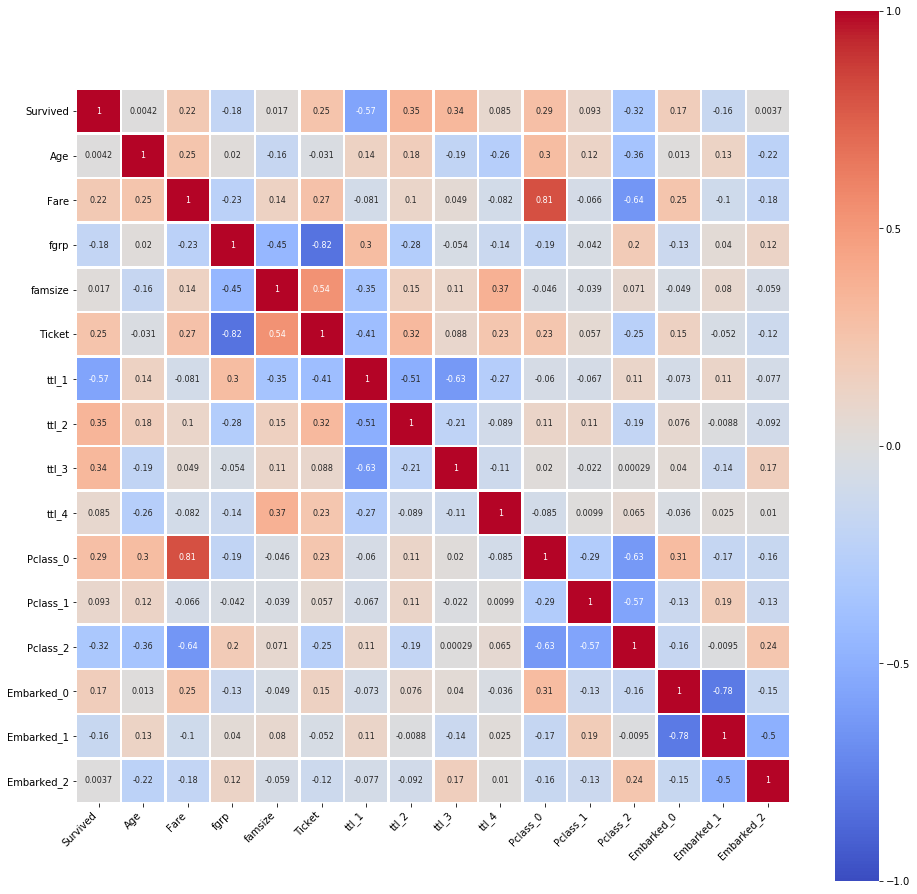

In [484]:
fig = plt.figure()
fig.set_size_inches(16, 16)
corr_matrix = data.drop(columns='PassengerId').corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

#### Train base estimators for stacking model

In [485]:
X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

In [486]:
#common random_state
random_state=30
#cross validation strategy
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
#cross validation metrics
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'roc_auc'

In [487]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [342]:
base_scores = {}

In [436]:
X_train, X_test, y_train, y_test =model_selection.train_test_split(X, y, test_size=0.3, shuffle=True, random_state=30)

#### LinearDiscriminantAnalysis

In [488]:
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cv_rep(lda, X, y, cv, scoring)
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.816480  0.873633         0.827477
std_train            0.010833  0.012412         0.009720
mean_test            0.800556  0.862939         0.814300
std_test             0.020248  0.027172         0.019079


In [489]:
param_ranges = {'solver': ['svd', 'lsqr', 'eigen'],}
lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.816480  0.873633         0.827477
std_train            0.010833  0.012412         0.009720
mean_test            0.800556  0.862939         0.814300
std_test             0.020248  0.027172         0.019079
{'solver': 'lsqr'}


In [344]:
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1066]:
# Save model
pickle.dump(lda, open('lda_01.mdl', 'wb'))

In [440]:
feature_importance(lda, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,famsize,Age,ttl,Fare,Sex,fgrp,Ticket,Cabin,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
LinearDiscriminantAnalysis,0.014925,0.007463,0.007463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### QuadraticDiscriminantAnalysis

In [345]:
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]], reg_param=0.08989795918367348)
scores = cv_rep(qda, X, y, cv, scoring)
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.816702  0.873010         0.834321
std_train            0.012609  0.007743         0.008572
mean_test            0.803580  0.845075         0.823655
std_test             0.021413  0.016854         0.018246


In [346]:
param_ranges = {'reg_param': np.linspace(0.001,0.1,99)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.816550  0.873028         0.834361
std_train            0.012453  0.007719         0.008814
mean_test            0.803763  0.845110         0.824003
std_test             0.022291  0.016683         0.017555
{'reg_param': 0.09090816326530612}


c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [347]:
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1067]:
# Save model
pickle.dump(qda, open('qda_01.mdl', 'wb'))

In [445]:
feature_importance(qda, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\00_data\python38\lib\site-packages\sklearn\discriminant_analy

Feature,ttl,famsize,Age,Embarked_0,Fare,Sex,Embarked_2,Ticket,Cabin,Pclass_1,Pclass_2,Embarked_1,Pclass_0,fgrp
QuadraticDiscriminantAnalysis,0.041045,0.022388,0.018657,0.007463,0.003731,0.003731,0.003731,0.0,0.0,0.0,0.0,0.0,-0.003731,-0.007463


#### AdaBoostClassifier

In [470]:
abc = ens.AdaBoostClassifier(algorithm='SAMME.R', 
                             learning_rate=0.1,
                             n_estimators=65,
                             random_state=random_state)
scores = cv_rep(abc, X, y, cv, scoring)
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.819392  0.882837         0.833791
std_train            0.010035  0.011284         0.009941
mean_test            0.800065  0.862486         0.818257
std_test             0.020917  0.020684         0.021233


In [471]:
param_ranges = {'n_estimators': np.arange(5, 100, 20), 'learning_rate': np.linspace(0.001, 0.5, 40)}
abc, scores = train_best_model(abc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.819792  0.874016         0.833128
std_train            0.010630  0.012356         0.011217
mean_test            0.804434  0.864672         0.821315
std_test             0.023035  0.024304         0.022183
{'learning_rate': 0.18012820512820513, 'n_estimators': 25}


In [472]:
data = family_groups_encoder(data_test.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

# data['Age_na'] = 0
# age_na_mask = {}
# for pid in data['PassengerId']:
#     if pid in data.loc[data['Age'].notna(), 'PassengerId']:
#         age_na_mask[pid] = 1
#     else:
#         age_na_mask[pid] = 0
# data['Age_na'] = data['PassengerId'].apply(lambda i: age_na_mask[i])

data = age_predictor(data, age_cls_model, age_reg_model)
data = cabin_encoder(data)

data = data[['PassengerId', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

In [473]:
data = pd.get_dummies(data, columns=['Pclass', 'Embarked'])

In [475]:
data = data.drop(columns=['Sex', 'Cabin'])

In [476]:
X = data.drop(columns=['PassengerId'])

In [477]:
data['Survived'] = abc.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("df_submission_abc.csv", index=False)

In [249]:
base_scores['abc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1068]:
# Save model
# pickle.dump(abc, open('abc_01.mdl', 'wb'))

Optimal number of features : 7
Features to drop: 

['fgrp', 'ttl_2', 'ttl_3', 'ttl_4', 'Embarked_2']


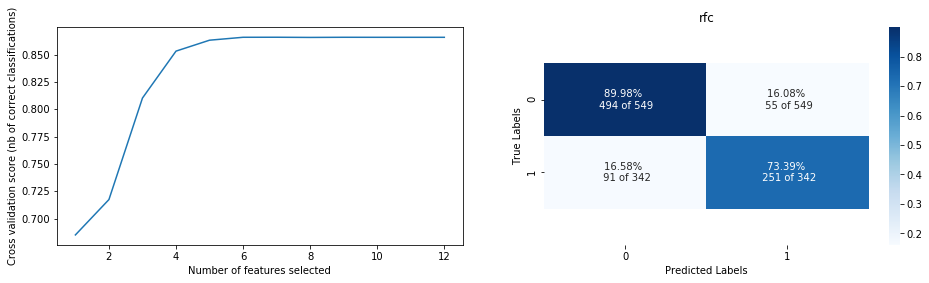

In [351]:
rfecv = feature_selection.RFECV(estimator=abc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(abc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='rfc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [352]:
feature_importance(abc, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

NameError: name 'feature_importance' is not defined

#### ExtraTreesClassifier

In [353]:
etc = ens.ExtraTreesClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                               n_estimators=95,
                               max_depth=4,
                               ccp_alpha=0.0)
scores = cv_rep(etc, X, y, cv, scoring)
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.812536  0.874701         0.819660
std_train            0.011403  0.009642         0.011041
mean_test            0.791645  0.841415         0.802205
std_test             0.025304  0.017769         0.023958


In [354]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(60, 100, 5),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821111  0.916661         0.898818
std_train            0.008698  0.007884         0.007981
mean_test            0.795887  0.852192         0.815942
std_test             0.021305  0.020800         0.019419
{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 90}


In [355]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 60)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.816519  0.908037         0.840961
std_train            0.010396  0.007721         0.009794
mean_test            0.796617  0.854616         0.808436
std_test             0.022641  0.021376         0.020993
{'ccp_alpha': 0.001}


In [249]:
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1069]:
# Save model
pickle.dump(etc, open('etc_01.mdl', 'wb'))

Optimal number of features : 14
Features to drop: 

[]


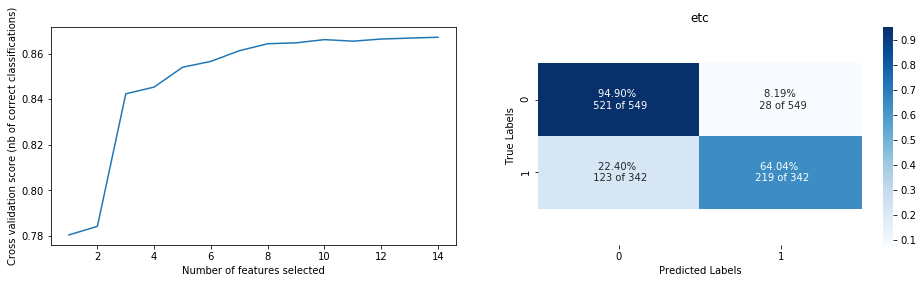

In [457]:
rfecv = feature_selection.RFECV(estimator=etc, step=1, min_features_to_select=1, cv=cv, scoring=refit, n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.figure()
fig.set_size_inches(16,4)
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Cross validation score (nb of correct classifications)")
ax.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plot_confusion_matrix(etc, X, y, ax=fig.add_subplot(1,2,2), normalize=True, title='etc')

print('Features to drop: \n')
feats = []
for i, m in zip(X.columns, rfecv.get_support()):
    if not m:
        feats.append(i)
print(feats)

In [458]:
feature_importance(etc, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,Sex,ttl,Pclass_2,Pclass_0,fgrp,famsize,Pclass_1,Age,Fare,Ticket,Cabin,Embarked_0,Embarked_2,Embarked_1
ExtraTreesClassifier,0.022388,0.022388,0.011194,0.003731,0.0,0.0,0.0,-0.007463,-0.007463,-0.007463,-0.007463,-0.007463,-0.007463,-0.011194


#### RandomForestClassifier

In [356]:
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=20,
                                 max_depth=5,
                                 ccp_alpha=0.04)
scores = cv_rep(rfc, X, y, cv, scoring)
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.805945  0.851012         0.809527
std_train            0.012512  0.013463         0.016010
mean_test            0.784072  0.826870         0.790395
std_test             0.020375  0.024046         0.021880


In [357]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(5, 100, 10),
                'max_depth': np.arange(3, 10)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.808801  0.868186         0.825270
std_train            0.010182  0.010763         0.019687
mean_test            0.790677  0.849114         0.813264
std_test             0.028121  0.021497         0.028765
{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 75}


In [358]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.1, 60)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.852676  0.924798         0.865737
std_train            0.009079  0.008762         0.010096
mean_test            0.800177  0.866099         0.826570
std_test             0.019637  0.016601         0.019531
{'ccp_alpha': 0.011067796610169493}


In [253]:
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1070]:
# Save model
pickle.dump(rfc, open('rfc_01.mdl', 'wb'))

In [464]:
feature_importance(rfc, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,ttl,Sex,Pclass_0,famsize,Cabin,Pclass_1,Fare,Age,Ticket,Pclass_2,Embarked_1,fgrp,Embarked_0,Embarked_2
RandomForestClassifier,0.029851,0.003731,0.003731,-0.003731,-0.003731,-0.003731,-0.007463,-0.011194,-0.011194,-0.011194,-0.011194,-0.014925,-0.014925,-0.022388


#### LogisticRegression

In [359]:
lr = lm.LogisticRegression(class_weight=class_weights, random_state=random_state, max_iter=200, n_jobs=-1,
                           penalty='l2',
                           solver='liblinear',
                           dual=False,
                           C=1.3122448979591839)
scores = cv_rep(lr, X, y, cv, scoring)
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.796515  0.851911         0.797398
std_train            0.013825  0.012253         0.014421
mean_test            0.780071  0.830912         0.784879
std_test             0.020893  0.028704         0.020794


In [360]:
param_ranges = {'C': np.linspace(0.01, 5, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.795451  0.850184         0.795899
std_train            0.014216  0.011906         0.014291
mean_test            0.780677  0.836361         0.785787
std_test             0.020691  0.025008         0.020733
{'C': 0.2136734693877551, 'solver': 'lbfgs'}


In [256]:
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1071]:
# Save model
pickle.dump(lr, open('lr_01.mdl', 'wb'))

In [469]:
feature_importance(lr, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,famsize,ttl,Pclass_0,Pclass_2,Age,Fare,Sex,fgrp,Ticket,Cabin,Pclass_1,Embarked_0,Embarked_1,Embarked_2
LogisticRegression,0.026119,0.022388,0.003731,0.003731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
coeff_df = pd.DataFrame(X.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(lr.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)
coeff_df

,Feature,Correlation
0,Fare,-0.008438
1,fgrp,-0.150587
2,famsize,-0.106839
3,Ticket,0.123621
4,Cabin,-0.115855
5,ttl_1,0.707815
6,ttl_2,-1.771354
7,ttl_3,0.837944
8,ttl_4,0.606137
9,Pclass_0,0.327086


#### RidgeClassifier

In [361]:
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state,
                        alpha=11.122448979591837)
scores = cv_rep(rc, X, y, cv, scoring)
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.796515  0.849686         0.797443
std_train            0.012455  0.012144         0.012488
mean_test            0.784375  0.831459         0.789984
std_test             0.020047  0.025799         0.018865


In [362]:
param_ranges = {'alpha': np.linspace(1, 45, 99)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.797399  0.847597         0.797630
std_train            0.012749  0.011846         0.012460
mean_test            0.784557  0.832807         0.789984
std_test             0.019321  0.024876         0.018865
{'alpha': 28.387755102040817}


In [259]:
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1072]:
# Save model
pickle.dump(rc, open('rc_01.mdl', 'wb'))

In [474]:
feature_importance(rc, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,famsize,ttl,Age,Cabin,Fare,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2,Sex,fgrp,Ticket
RidgeClassifier,0.029851,0.026119,0.007463,0.003731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003731,-0.003731,-0.003731


#### SVC

In [490]:
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=9428.57142857143)
scores = cv_rep(svc, X, y, cv, scoring)
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.812444  0.868858         0.819677
std_train            0.012508  0.012901         0.012651
mean_test            0.794131  0.834272         0.805303
std_test             0.019960  0.026749         0.018044


In [496]:
param_ranges = {'C': np.linspace(1000, 3000, 55)}
svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.810204  0.866953         0.818215
std_train            0.012599  0.010534         0.012236
mean_test            0.794684  0.848270         0.803633
std_test             0.027810  0.021453         0.019968
{'C': 2037.037037037037}


In [262]:
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1073]:
# Save model
pickle.dump(svc, open('svc_01.mdl', 'wb'))

In [479]:
feature_importance(svc, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,ttl,famsize,Age,Fare,Sex,fgrp,Ticket,Cabin,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
SVC,0.093284,0.003731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [365]:
nusvc = svm.NuSVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
                 nu=0.5102089795918366)
scores = cv_rep(nusvc, X, y, cv, scoring)
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]
print(scores)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.712988  0.788560         0.719696
std_train            0.042055  0.032009         0.043731
mean_test            0.698935  0.751136         0.704086
std_test             0.047957  0.039595         0.047510


In [373]:
param_ranges = {'nu': np.linspace(0.1,1.0,99)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.719011  0.806597         0.746580
std_train            0.027869  0.012578         0.021261
mean_test            0.701780  0.762986         0.714169
std_test             0.040237  0.037030         0.030313
{'nu': 0.5775510204081633}


In [265]:
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [1074]:
# Save model
pickle.dump(nusvc, open('nusvc_01.mdl', 'wb'))

In [1075]:
feature_importance(nusvc, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,ttl,Age,Fare,Sex,fgrp,famsize,Ticket,Cabin,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
NuSVC,0.097015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Base estimators scores

In [266]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,rfc,etc,abc,qda,lr,rc,lda,nusvc,svc
test_score,0.877873,0.875178,0.872880,0.870921,0.860606,0.859576,0.858741,0.849238,0.842707
train_score,0.935035,0.920453,0.896831,0.896785,0.872949,0.871852,0.872550,0.885325,0.922658


In [560]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,rfc,etc,lr,abc,lda,rc,qda,svc,nusvc
test_score,0.873922,0.868170,0.867432,0.867358,0.866531,0.866296,0.855911,0.847932,0.841377
train_score,0.922455,0.903357,0.877218,0.883552,0.875437,0.875994,0.883423,0.862059,0.854020


In [367]:
base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc,'nusvc':nusvc}

In [368]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

c:\00_data\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


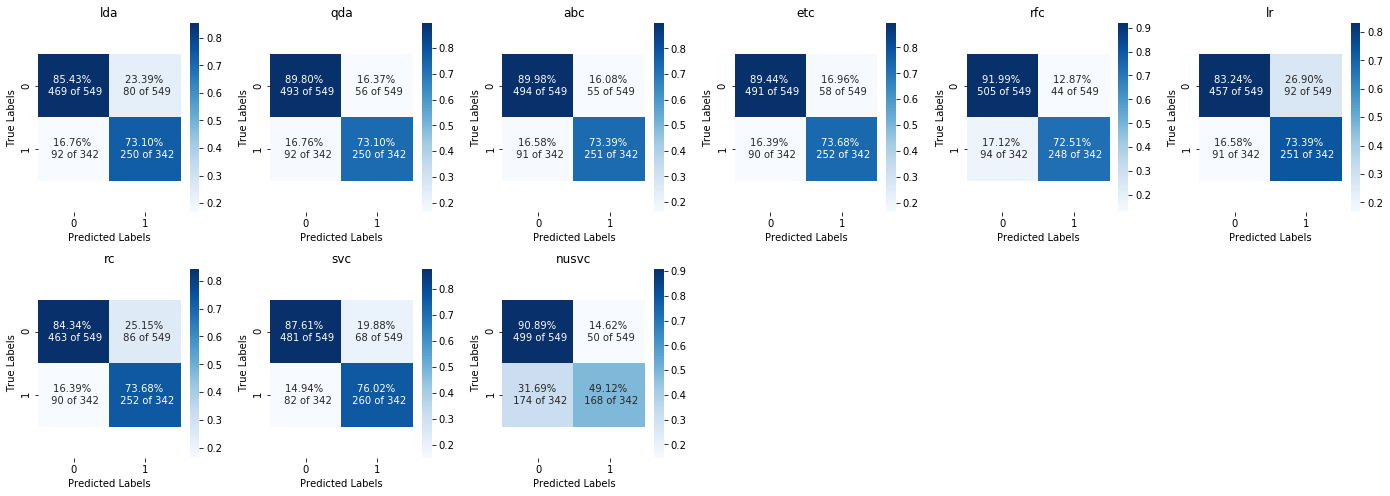

In [369]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

In [91]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

In [92]:
def base_models_predictions_proba(models, X):
    X0 = None
    X1 = None
    for i, model in models:
        proba_0 = model.predict_proba(X)[:,0]
        proba_1 = model.predict_proba(X)[:,1]
        if X0 is None:
            X0 = pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame()
        else:
            X0 = X0.merge(pd.Series(proba_0, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
        
        if X1 is None:
            X1 = pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame()
        else:
            X1 = X1.merge(pd.Series(proba_1, name='{0}_proba'.format(i)).to_frame(), left_index=True, right_index=True)
    return (X0, X1)

#### Base estimators correlation matrix

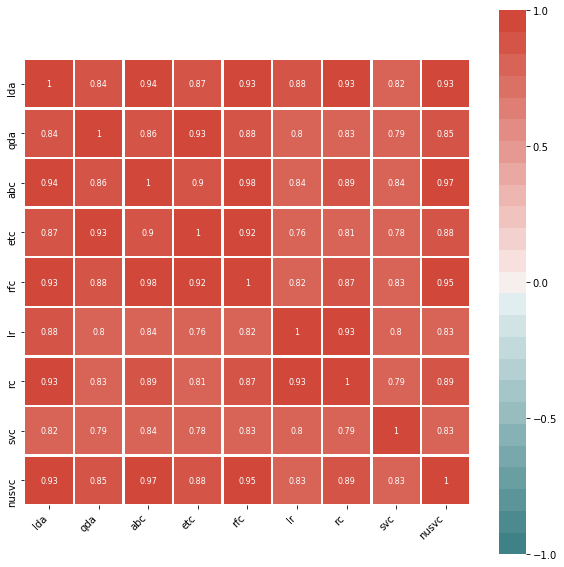

In [270]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [271]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,abc,rfc,lda,nusvc,rc,etc,qda,lr,svc
cc,0.799798,0.797601,0.792392,0.792011,0.770758,0.760576,0.752862,0.740202,0.719466


#### Select less correlated models

In [272]:
base_models_surv_dic = {'lda':lda,'qda':qda,'etc':etc,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc,'nusvc':nusvc}

In [273]:
# base_models_surv_dic = {'lda':lda,'qda':qda,'etc':etc,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc}

In [274]:
# base_models_surv_dic = {'lda':lda,'qda':qda,'abc':abc,'etc':etc,'rc':rc,'svc':svc}

In [275]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

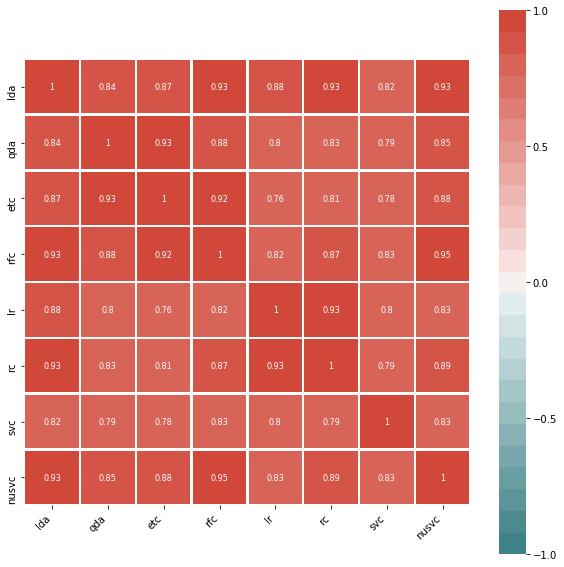

In [276]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [277]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,rfc,lda,nusvc,rc,etc,qda,lr,svc
cc,0.775408,0.773966,0.770291,0.756259,0.743253,0.739797,0.72811,0.704744


#### Compare stacking classifier score for different final estimator models

In [278]:
def train_final_models(models, X, y, score, cv_folds=5):
    scores = {}
    fin_models = []
    for m in models:
        model_st = ens.StackingClassifier(estimators=base_models_surv,
                                          final_estimator=m[1],
                                          cv=cv_folds, 
                                          stack_method='predict', 
                                          n_jobs=-1)
        res = cv_rep(model_st, X, y, cv, scoring)
        scores[m[0]] = [res.loc['mean_test', score], res.loc['mean_train', score]]
        fin_models.append((m[0], model_st))
    scores = pd.DataFrame(scores, index=['Test_score', 'Train_score']).sort_values(by='Test_score', axis=1,ascending=False)
    return fin_models, scores

In [279]:
final_models_surv = [('abc', ens.AdaBoostClassifier()),
                     ('etc', ens.ExtraTreesClassifier()),
                     ('rfc', ens.RandomForestClassifier()),
                     ('lr', lm.LogisticRegression()),
                     ('svc', svm.SVC())]

In [280]:
fin_models, scores = train_final_models(final_models_surv, X, y, cv_folds=5, score=refit)

In [281]:
scores

,lr,abc,rfc,etc,svc
Test_score,0.839326,0.837664,0.818067,0.812786,0.808841
Train_score,0.889025,0.887742,0.873309,0.864628,0.860688


In [576]:
scores

,lr,abc,rfc,etc,svc
Test_score,0.826069,0.825307,0.818185,0.813722,0.812142
Train_score,0.852913,0.852089,0.848005,0.846981,0.843848


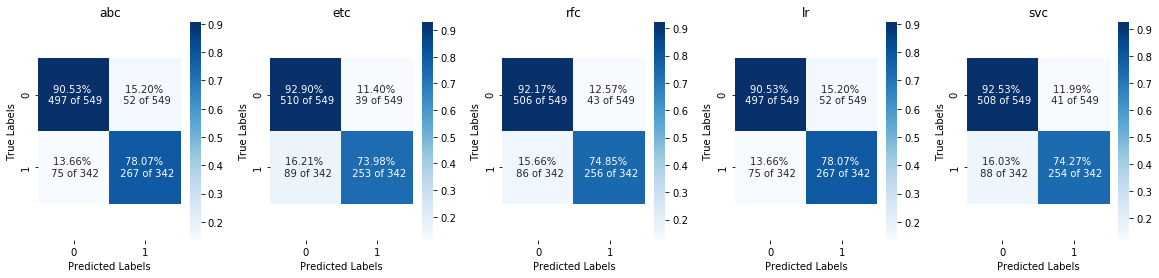

In [282]:
grd_n = len(fin_models)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(fin_models):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

#### Train stacking classifier

In [283]:
model_st_abc = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.AdaBoostClassifier(random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

cv_rep(model_st_abc, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.845417,0.887742,0.865296
std_train,0.017748,0.009733,0.011950
mean_test,0.800309,0.837664,0.818225
std_test,0.023241,0.028978,0.026821


In [284]:
param_ranges = {'final_estimator__n_estimators': np.arange(50, 120, 10), 'final_estimator__learning_rate': np.linspace(0.1, 0.8, 20)}
model_st_abc, scores = train_best_model(model_st_abc, param_ranges, X, y, scoring, cv, refit=refit)


            balanced_accuracy   roc_auc  precision_macro
mean_train           0.844321  0.889072         0.863392
std_train            0.017618  0.009156         0.008989
mean_test            0.801218  0.841580         0.820060
std_test             0.022873  0.028352         0.027615
{'final_estimator__learning_rate': 0.39473684210526316, 'final_estimator__n_estimators': 90}


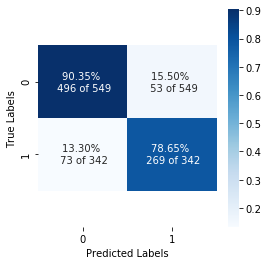

In [285]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st_abc, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [1076]:
# Save model
pickle.dump(model_st_abc, open('model_st_abc_01.mdl', 'wb'))

In [498]:
# model_st = pickle.load(open('model_st_top11.mdl', 'rb'))

In [812]:
feature_importance(model_st_abc, 
                   X_train, y_train, X_test, y_test, 
                   metric='roc_auc', 
                   label=None).T

Feature,ttl,Pclass_2,Fare,fgrp,famsize,Pclass_1,Embarked_1,Age,Sex,Embarked_0,Embarked_2,Cabin,Ticket,Pclass_0
StackingClassifier,0.029851,0.018657,0.014925,0.014925,0.014925,0.014925,0.014925,0.011194,0.007463,0.003731,0.003731,0.0,-0.003731,-0.003731


In [1052]:
model_st_lr = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=lm.LogisticRegression(class_weight=class_weights, 
                                                                        random_state=random_state, 
                                                                        max_iter=200, 
                                                                        n_jobs=-1,
                                                                        penalty='l2',
                                                                        solver='liblinear',
                                                                        dual=False,
                                                                        C=1.0),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

cv_rep(model_st_lr, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.831658,0.861627,0.839831
std_train,0.012623,0.014937,0.009219
mean_test,0.802866,0.831386,0.813910
std_test,0.022960,0.025193,0.022587


In [1053]:
param_ranges = {'final_estimator__C': np.linspace(0.01, 5, 99), 'final_estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
model_st_lr, scores = train_best_model(model_st_lr, param_ranges, X, y, scoring, cv, refit=refit)


            balanced_accuracy   roc_auc  precision_macro
mean_train           0.827367  0.860176         0.834557
std_train            0.011089  0.014884         0.008760
mean_test            0.808508  0.831686         0.817834
std_test             0.024658  0.027129         0.020949
{'final_estimator__C': 0.06091836734693878, 'final_estimator__solver': 'newton-cg'}


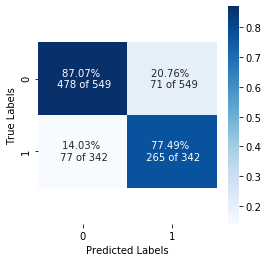

In [1054]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st_lr, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [1077]:
# Save model
pickle.dump(model_st_lr, open('model_st_lr_01.mdl', 'wb'))

## Predict test set

#### Preprocessind data

In [593]:
# data = family_groups_encoder(data_test.copy(), fgrp_mask)
# data = fare_encoder(data, fare_mask)
# data = fare_transformer(data)

# data = ticket_encoder(data, ticket_mask)

# data = title_encoder(data)
# data = sex_encoder(data)
# data = fam_size(data)

# data = embarked_encoder(data)
# data = pclass_encoder(data)

# # data = age_predictor(data, age_cls_model, age_reg_mogel)
# # data = cabin_encoder(data)
# # data = data[['PassengerId', 'Survived', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

In [595]:
# data = cabin_encoder(data)
# data = data = data[['PassengerId', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

In [596]:
# data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])

In [597]:
# data['fgrp'] = data['fgrp'].apply(lambda i: len(data.loc[data['fgrp']==i].index))

In [287]:
data = family_groups_encoder(data_test.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = fare_transformer(data)

data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

# data['Age_na'] = 0
# age_na_mask = {}
# for pid in data['PassengerId']:
#     if pid in data.loc[data['Age'].notna(), 'PassengerId']:
#         age_na_mask[pid] = 1
#     else:
#         age_na_mask[pid] = 0
# data['Age_na'] = data['PassengerId'].apply(lambda i: age_na_mask[i])

data = age_predictor(data, age_cls_model, age_reg_model)
data = cabin_encoder(data)

data = data[['PassengerId', 'Age', 'Fare', 'Sex', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked', 'Cabin']]

In [288]:
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])

In [289]:
# data['fgrp'] = data['fgrp'].apply(np.log)

In [290]:
# data['Ticket'] = data['Ticket'].apply(lambda i: len(data.loc[data['Ticket']==i].index))

In [291]:
stdsc = prep.StandardScaler(copy=True, with_mean=True, with_std=True)

In [292]:
data['fgrp'] = stdsc.fit_transform(np.array(data['fgrp']).reshape(-1,1))

In [293]:
data['famsize'] = data['famsize'].apply(lambda i: len(data.loc[data['famsize']==i].index))

In [294]:
data['famsize'] = stdsc.fit_transform(np.array(data['famsize']).reshape(-1,1))

In [295]:
data

,PassengerId,Age,Fare,Sex,fgrp,famsize,Ticket,Cabin,ttl_1,ttl_2,ttl_3,ttl_4,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
10,902,3.162173,2.066331,0,0.915663,0.797379,1,0,1,0,0,0,0,0,1,0,1,0
22,914,3.785325,3.455790,1,0.915663,0.797379,1,0,0,1,0,0,1,0,0,0,1,0
29,921,3.216079,3.076353,0,-1.093766,-1.198577,3,0,1,0,0,0,0,0,1,1,0,0
33,925,3.106622,1.768576,1,-0.726187,-1.636466,4,0,0,1,0,0,0,0,1,0,1,0
36,928,3.119907,2.085672,1,0.915663,0.797379,1,0,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1301,3.000000,1.524243,1,-0.726187,-1.198577,3,0,0,0,1,0,0,0,1,0,1,0
411,1303,37.000000,3.401197,1,-1.093766,-1.025459,3,1,0,1,0,0,1,0,0,0,0,1
412,1304,28.000000,2.050913,1,0.915663,0.797379,1,0,0,0,1,0,0,0,1,0,1,0
414,1306,39.000000,4.690430,1,0.915663,0.797379,3,1,0,1,0,0,1,0,0,1,0,0


#### Make predictions

In [296]:
X = data.drop(columns=['PassengerId', 'Sex'])

In [297]:
# model_st = pickle.load(open('model_st_03.mdl', 'rb'))

In [298]:
data['Survived'] = model_st_abc.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("df_submission_abc.csv", index=False)

In [1064]:
# model_st = pickle.load(open('model_st_04.mdl', 'rb'))

In [1065]:
data['Survived'] = model_st_lr.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("df_submission_lr.csv", index=False)